In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
device = torch.device('cpu')
if (torch.cuda.is_available()):
    device = torch.device('cuda')

## HYPERPARAMS

In [6]:
dataroot = '../storage/data/AS_storage/'
workers = 4
batch_size = 32
image_size = 784
nc = 1
nz = 100

num_epochs = 50
lr = 0.0002
momentum = 0.5
dampening = 0

k=1

## DATA

In [9]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_ds = torchvision.datasets.FashionMNIST(dataroot, train=True, download=True, transform=transforms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers)
print('Length of dataset:',len(train_ds))

Extracting ../storage/data/AS_storage/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../storage/data/AS_storage/FashionMNIST/raw


Extracting ../storage/data/AS_storage/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../storage/data/AS_storage/FashionMNIST/raw


Extracting ../storage/data/AS_storage/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../storage/data/AS_storage/FashionMNIST/raw




Extracting ../storage/data/AS_storage/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../storage/data/AS_storage/FashionMNIST/raw
Processing...


/opt/conda/envs/fastai/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Length of dataset: 60000


0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot

Images shape: torch.Size([32, 1, 28, 28])
Labels: tensor([1, 5, 6, 1, 2, 7, 9, 3, 0, 9, 7, 1, 3, 9, 1, 9, 3, 0, 2, 7, 9, 5, 0, 8,
        6, 1, 1, 4, 3, 9, 9, 5])


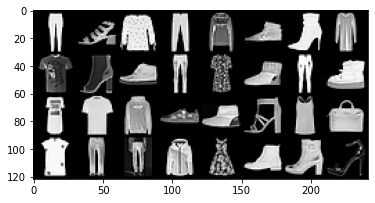

In [14]:
for images, labels in train_dl:
    print('Images shape:',images.shape)
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1,2,0))
    print('Labels:',labels)
    break

## MODELS

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(nz , 256),
            nn.LeakyReLU(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256 , 512),
            nn.LeakyReLU(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 1024),
            nn.LeakyReLU(0.2),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(1024 , 784),
            nn.Tanh()
        )
        
    def forward(self, batch):
        #RECIEVES BATCH OF SIZE (batch_size, nz)
        batch = batch.view(batch.size(0), -1)
        out = self.fc1(batch)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(784 , 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256 , 1),
            nn.Sigmoid()
        )
        
    def forward(self, batch):
        #RECIEVES BATCH OF SIZE (batch_size, 784) or (batch_size, 1, 28, 28)
        batch = batch.view(batch.size(0), -1)
        out = self.fc1(batch)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [17]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## LOSS FUNCTIONS

In [18]:
opt_g = torch.optim.Adam(generator.parameters(), lr)
opt_d = torch.optim.Adam(discriminator.parameters(), lr)

criterion = nn.BCELoss()

## PRE-TRAIN FUNCTIONS

In [19]:
real_labels = torch.ones(batch_size,1).to(device)
fake_labels = torch.zeros(batch_size,1).to(device)

In [20]:
fixed_noise = torch.randn(batch_size, nz).to(device)

## PRE-TRAIN TEST

In [21]:
sample = generator(fixed_noise).detach()
print("Generated Samples:", sample.shape)

sample_output = discriminator(sample).detach()
print("Sample Outputs:", sample_output.shape)

Generated Samples: torch.Size([32, 784])
Sample Outputs: torch.Size([32, 1])


## TRAIN

In [23]:
start_time = time.time()

loss_d = []
loss_g = []

for epoch in range(num_epochs):
    loss_d_ = 0.0
    loss_g_ = 0.0
    for i, (images, _) in enumerate(train_dl):
        #DISCRIMINATOR
        opt_d.zero_grad()
        
        real_images = images.to(device)
        fake_images = generator(torch.randn(batch_size, nz).to(device)).detach()
        
        real_outputs = discriminator(real_images) 
        fake_outputs = discriminator(fake_images) 
        
        real_loss = criterion(real_outputs, real_labels)
        fake_loss = criterion(fake_outputs, fake_labels)
        real_loss.backward()
        fake_loss.backward()
        
        opt_d.step()
        
        loss_d_ += real_loss + fake_loss
        
        #GENERATOR
        opt_g.zero_grad()
        
        output = discriminator(generator(torch.randn(batch_size, nz).to(device)))
        
        loss = criterion(output, real_labels)
        loss.backward()
        
        opt_g.step()
        
        loss_g_ += loss
    
    epoch_loss_g = loss_g_/i
    epoch_loss_d = loss_d_/i
    loss_g.append(epoch_loss_g)
    loss_d.append(epoch_loss_d)
    print(f'{epoch}/{num_epochs} | Generator_Loss: {epoch_loss_g:.8f} | Discriminator_Loss: {epoch_loss_d:.8f} | Time Elapsed: {time.time() - start_time:.0f} seconds')
    
    if epoch%10==0:
        sample = generator(fixed_noise).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8, pad_value=1, normalize=False)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join('visuals', 'FashionMNIST_VANILLA_GAN_{}.jpg'.format(str(epoch).zfill(3))))    
    
print(f'\nTOTAL DURATION: {time.time() - start_time:.0f} seconds')
sample = generator(fixed_noise).detach()
grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8, pad_value=1, normalize=False)   
torchvision.utils.save_image(grid.detach().cpu(), os.path.join('visuals', 'FashionMNIST_VANILLA_GAN_50.jpg'))    

0/50 | Generator_Loss: 1.25788069 | Discriminator_Loss: 1.16339052 | Time Elapsed: 20 seconds
1/50 | Generator_Loss: 1.21234274 | Discriminator_Loss: 1.08271182 | Time Elapsed: 40 seconds
2/50 | Generator_Loss: 1.41595745 | Discriminator_Loss: 0.95831674 | Time Elapsed: 60 seconds
3/50 | Generator_Loss: 1.32675791 | Discriminator_Loss: 0.99910009 | Time Elapsed: 79 seconds
4/50 | Generator_Loss: 1.13240492 | Discriminator_Loss: 1.08856058 | Time Elapsed: 99 seconds
5/50 | Generator_Loss: 1.17248261 | Discriminator_Loss: 1.08003676 | Time Elapsed: 119 seconds
6/50 | Generator_Loss: 1.22404122 | Discriminator_Loss: 1.02434230 | Time Elapsed: 139 seconds
7/50 | Generator_Loss: 1.26337671 | Discriminator_Loss: 0.99279761 | Time Elapsed: 159 seconds
8/50 | Generator_Loss: 1.25017619 | Discriminator_Loss: 0.99388283 | Time Elapsed: 179 seconds
9/50 | Generator_Loss: 1.20722091 | Discriminator_Loss: 1.02605617 | Time Elapsed: 200 seconds
10/50 | Generator_Loss: 1.26020312 | Discriminator_Loss

## EVALUATION

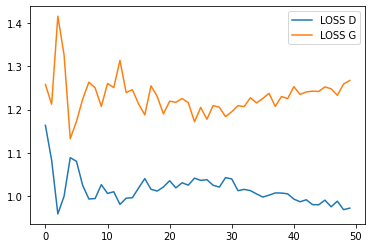

In [24]:
plt.figure()

plt.plot(loss_d, label='LOSS D')
plt.plot(loss_g, label='LOSS G')
plt.legend()
plt.show()

## SAVING

In [26]:
torch.save(generator.state_dict(), './fashion_mnist_vanilla_gan_generator.pt')
torch.save(discriminator.state_dict(), './fashion_mnist_vanilla_gan_discriminator.pt')